In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use(['seaborn-ticks', 'seaborn-talk'])

import numpy as np
import pandas as pd
import jax

# A Multilayer Perceptron Classifier using `jax`

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1CLxQ_S4sB0W1LS6_kLcGbGLnXlB_FqFY?usp=sharing)

To apply `jax` to a "real" problem, we will build a simple [multilayer perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron), a type of feed-forward artifical neural network, and use it to solve a simple classification problem (the circle/disc separation problem from the [scikit-learn documentation](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html#classifier-comparison)).

## Generating some data

As always, we start our demo with a bit of toy data to play with. In this case, scikit-learn provides some really nice built-in tools for creating datasets for different types of classification problems. For our purposes we'll use the [`make_circles()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html#sklearn.datasets.make_circles) function to create a set of concentric circles, each with different labels.

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_circles

n = 200

X, y = make_circles(noise=0.2, factor=0.5, random_state=1337, n_samples=n)
X = StandardScaler().fit_transform(X)

In preparation for life later on, let's cull 30% of the data from our toy dataset to hold out for testing in our classification problem.

In [3]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, random_state=42)

# Save a copy as a pandas DataFrame
train_df = pd.DataFrame(
    {'xc': X_train[:, 0], 'yc': X_train[:, 1], 'label': y_train, 'set': 'train'}
)
test_df = pd.DataFrame(
    {'xc': X_test[:, 0], 'yc': X_test[:, 1], 'label': y_test, 'set': 'test'}
)
data_df = pd.concat([train_df, test_df])

Let's visualize the data just to get a sense for what it looks like. 

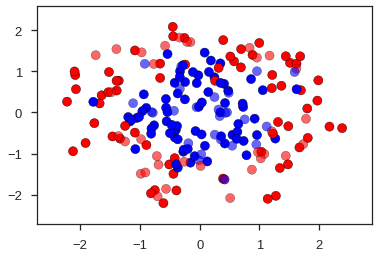

In [4]:
from matplotlib.colors import ListedColormap

# Set up some data for visualization (a gridded mesh)
h = 0.02  # step size in the mesh
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, h), 
    np.arange(y_min, y_max, h)
)
coords = np.c_[xx.ravel(), yy.ravel()]

# Plot the dataset
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def eval_plot(Z=None):
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))

    # Decision boundary
    if Z is not None:
        ax.contourf(xx, yy, Z, cmap=cm, alpha=0.8)

    ## Training points
    ax.scatter('xc', 'yc', data=train_df, c='label', cmap=cm_bright, edgecolors='k')
    ## Testing points
    ax.scatter('xc', 'yc', data=test_df, c='label', cmap=cm_bright, alpha=0.6, edgecolors='k')

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    return fig, ax

fig, ax = eval_plot()

## Baseline - `scikit-learn`

To set a reference, let's train a standard [`MLPClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier) from the scikit-learn library. There's nothing fancy here! Just an off-the-shelf model fit to our data.


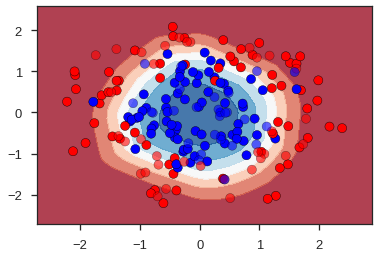

In [5]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(alpha=1, max_iter=1000)
clf.fit(X_train, y_train)

Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)

fig, ax = eval_plot(Z)

Not too bad! 

This is a bit of a "hard" classification problem because there's a fair amount of intermingling between the red outer circle and the blue inner circle. Put another way, there isn't a very clean decision boundary... we can't just draw a circle and confidently know that on its interior we're in the "blue" domain and on the exterior we're in the "red" domain. Instead, we have a transition region, and the probability of being in the "blue" or "red" region correspondingly trades off as we move away from the center of the domain.

## Neural Networks with `jax.stax`

`jax` ships with a nice set of libraries demonstrating a wide variety of functionality. One of those libraries, [`stax`](https://jax.readthedocs.io/en/latest/jax.experimental.stax.html), is a simple tool that allows users to build and train neural networks. 

Let's use this library to build our own multilayer perceptron.

We start out by specifying our model. This is a little bit different with `stax` as opposed to libraries like `Keras` or `PyTorch` in that we use a _functional_ approach to composing transformations to apply to our data here.

`jax` is a "batteries included" deep learning library in the sense that it includes primitives implementing many of the canonical elements a user might incorporate into their models. For instance, it includes a wide variety of activation functions (such as `Relu` and `LogSoftmax`) as well as convolutional layers, batch norms, dropouts, and more.

You can also implement your components. Here, let's use a [swish activation function](https://en.wikipedia.org/wiki/Swish_function). The swish is a a weighted sigmoidal function,

$$\mathrm{swish}(x) = x \times \mathrm{sigmoid}(\beta x)= \frac{x}{1+\exp{(-\beta x)}}$$


/usr/local/lib/python3.6/dist-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


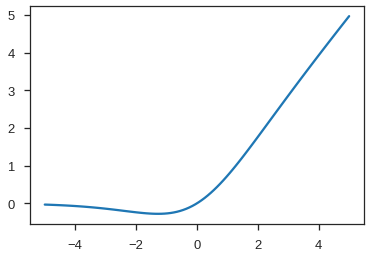

In [6]:
from jax.nn import sigmoid
from jax.experimental.stax import elementwise

def swish(x, beta=1):
    return x * sigmoid(beta * x)
Swish = elementwise(swish) # Save for later!

_x = np.linspace(-5, 5, 100)
plt.plot(_x, swish(_x));

The `stax.elementwise` invocation transforms our simple, scalar function to something that can be plugged in to a composed neural network built with `stax`, as we'll see in a moment.

Before we can solve our classification problem, we need to do a bit of setup. This involves three major steps:

1. Generate a model to train
2. Generate an optimizer to train the model
3. Instantiate the optimizer and model

We'll do each step in sequence.

**Generate a model to train**

In [7]:
from jax.experimental.stax import serial, Dense, Sigmoid

n_hidden = 64  # number of hidden connections in our MLP
n_out = 2  # we have a two-class prediction problem

init_random_params, predict = serial(
    Dense(n_hidden),
    Swish,
    Dense(n_out),
)

There's nothing unexpected about our neural network. We have one fully connected, hidden layer with a pre-configured number of outputs. We feed that into our "swish" activation function, and then pass those values into a final, fully-connected output layer which will interpret as probabilities of either of our two labels.

What _is_ probably a little unexpected is what our model generating function returns:

- `init_random_params` is a handle to a function which we will use to set the initial values of all the free parameters in our MLP
- `predict` is a handle to a function which feeds an input into our MLP and returns the emission from its output layer

Remember - this is a functional paradigm! It has some quirks but is easy to work with.

**Generate an optimizer to train the model**

In [8]:
from jax.experimental.optimizers import momentum

opt_init, opt_update, get_params = \
    momentum(step_size=0.05, mass=0.9)

Again, a bit of subverted expectations. Here, we instantiated a stochastic gradient descent optimizer with momentum. And, again, what we're returned isn't an object, but instead a triple of function handles:

- `opt_init` is a handle to a function which will initialize the optimizer with knowledge about our model parameters
- `opt_update` is a handle to a function which calls the update operation to increment the state of the optimizer using the gradient of the cost function we'll supply later
- `get_params` is a handle to a function which returns the present state of the parameters being optimized... it lets us actually perform predictions with a given state of our neural network as it is trained

All of these are tools which will be used as we move forward.

**Instantiate the optimizer and model**

In [9]:
from jax import random

# Prepare a random number generator to initialize the model
rng = random.PRNGKey(0)

# Initialize the model
_, init_params = init_random_params(rng, input_shape=(-1, 2))

# Initialize the optimizer
opt_state = opt_init(init_params)

If you've been following along, you probably could've predicted that this is where we'd be headed! First we use the function `init_random_params` we created to initialize the parameters of our model. We then feed the resulting parameters into `opt_init` to setup our optimizer.

The last thing we need to set up is our loss function. We'll use a simple cross-entropy loss since we're predicting labels for two classes. As a small technical detail, we used a fully connected output layer in our model, which outputs a "value" for each of the two classes in our classification problem. We didn't apply a final activation function. So, we need to do this when we score our outputs in our loss function, in order to compute probabilities.

As we've seen before, `jax` includes useful functions for this purpose. In our case, we'll apply the `log_softmax` function:

$$\mathrm{log\_softmax}(x) = \log\left(\frac{\exp(x_i)}{\sum_j\exp{x_j}}\right)$$

As a minor detail, note that `jax.experimental.stax.log_softmax` is just an alias for the even lighter-weight `jax.nn` module's `log_softmax()`. function. 

The result of this should be a value $\log(p)$ for each of our two classes. This is nice, because we will use a cross-entropy loss function:

$$H(y,p) = -\sum_i y_i \log(p_i)$$

Our cross-entropy function implemented here is a bit of a NumPy fancy-indexing hack and obfuscates what we're actually doing. But, it's actually pretty simply. Given an array `targets` containing `m` observations of either 0 or 1 (our two classes), we just need to pull out which of the two class probability predictions corresponds to the correct label. In simple Python this operation should look something like this:

``` python
loss = 0
for sample_prob, correct_label in zip(probs, targets):
    loss += sample_prob[correct_label]
```

As below, using fancy indexing we can simplify this:

``` python
m = len(probs)
loss = np.sum(probs[np.arange(m), targets)
```

In [10]:
import jax.numpy as jnp
from jax.experimental.stax import log_softmax

def loss(params, batch):
    """ Cross-entropy loss based on predicted labels in the batch """
    inputs, targets = batch
    output = predict(params, inputs)

    m = targets.shape[0]
    log_p = log_softmax(output)
    log_likelihood = -log_p[np.arange(m), targets]

    return jnp.mean(log_likelihood)

def accuracy(params, batch):
    """ Compute accuracy as a percentage of correct labels in batch """
    inputs, targets = batch
    output = predict(params, inputs)
    
    predicted_class = jnp.argmax(output, axis=1)

    return jnp.mean(predicted_class == targets)

We also defined a simple accuracy function -- the percentage of correct labels in a batch -- just for benchmarking.

## Training our model

Using the vanilla `stax` library, we're responsible for our own infrastructure for training the model. But, this is much less daunting then it stands. In general, training our model is a simple, iterative process where we update our parameters after measuring against a set of training data. 

At the heart of this iteration is a very simple training step:

In [11]:
from jax import jit, grad

@jit
def train_step(i, opt_state, batch):
    params = get_params(opt_state)
    return opt_update(i, grad(loss)(params, batch), opt_state)

In this step, we acquire the current "state" of our model, then update the optimizer by passing it the gradient of our loss function, evaluated for our training data. Most of the code here is just passing in the trackers for the state of our network and optimizer owing to the functional paradigm leveraged by `stax`.

We can now wrap the training step with an outer loop. At each iteration of the loop, we do the following:

1. Grab a batch of training data; in this case, we do not use mini-batches and simply leverage the full training set each step.
2. Execute the training step as described above.
3. Evaluate the loss and accuracy functions on both our training and test datasets for bookkeeping.
4. Print a diagnostic every handful of iterations.


In [12]:
from itertools import count

n_epochs = 250
use_batches = False
batch_size = 32
out_freq = 50

# Training loop
all_metrics = []
icount = count()
for i in range(n_epochs):

    # Prepare a batch of data and perform a training step
    train_batch = (X_train, y_train)
    opt_state = train_step(next(icount), opt_state, train_batch)

    # Evaluate the model accuracy so far
    params = get_params(opt_state)
    test_batch = (X_test, y_test)
    _metrics = {
        'train_loss': loss(params, train_batch),
        'test_loss': loss(params, test_batch),
        'train_acc': accuracy(params, train_batch),
        'test_acc': accuracy(params, test_batch)
    }
    all_metrics.append(_metrics)

    # Output some metrics if we're at a checkpoint
    if (i % out_freq) == 0:
        print(
            f"eval_epoch: {i+1:d}, ",
            f" loss: {_metrics['test_loss']:.4f}, ",
            f" accuracy: {_metrics['test_acc']*100:.2f}"
        )

eval_epoch: 1,   loss: 0.6913,   accuracy: 51.67
eval_epoch: 51,   loss: 0.5517,   accuracy: 80.00
eval_epoch: 101,   loss: 0.3674,   accuracy: 81.67
eval_epoch: 151,   loss: 0.3493,   accuracy: 83.33
eval_epoch: 201,   loss: 0.3459,   accuracy: 83.33


We can visualize the performance of the model over the training cycles:

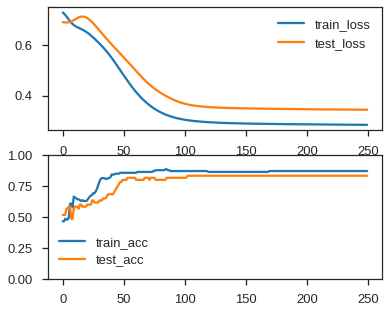

In [13]:
metrics_df = pd.DataFrame(all_metrics).astype(float)

fig, axs = plt.subplots(2, 1, figsize=(6, 5))
ax1, ax2 = axs

metrics_df[['train_loss', 'test_loss']].plot(ax=ax1)
metrics_df[['train_acc', 'test_acc']].plot(ax=ax2)
ax2.set_ylim(0, 1);

Unsurprisingly, we hit a plateau pretty quickly. Given the amount of noise in our test dataset, we can't perfectly "cleanly" separate out the two classes, as visualized below:

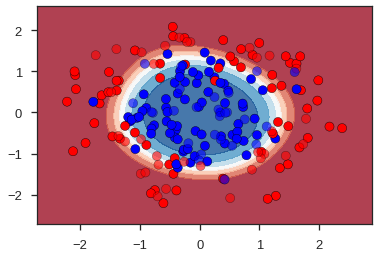

In [15]:
from jax.experimental.stax import softmax

logits = predict(params, coords)
cluster = jnp.argmax(logits, -1)
proba = softmax(logits)[:, 1]
# print(np.min(proba), np.max(proba))

Z = proba.reshape(xx.shape)
fig, ax = eval_plot(Z)

But that's basically it!

## Wrap-up

At this point, we could go back and start modifying our neural network, trying different classification functions, or possibly even implementing mini-batches for training. However, we have a fully-functional multilayer perceptron written natively in `jax` at this point, and all it required was a tiny bit of adjustment to the functional paradigm used to muck around with the components provided in the `stax` library. 